## Importing packages and libraries

In [ ]:
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Dropout,MaxPooling2D,Flatten, BatchNormalization, Activation
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split,KFold
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, smart_resize, array_to_img
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

## Reading the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/tcss555/training/profile/profile.csv', header=0, usecols=['userid','gender'] )

In [ ]:
os.chdir('/content/drive/MyDrive/tcss555/training/image/')

In [ ]:
filelist = (os.listdir('/content/drive/MyDrive/tcss555/training/image/'))

In [ ]:
x = []
y = []
for file in filelist:
    if file[:-4] in df.values:
      img = load_img(file)
      img_array = img_to_array(img)
      img_array = smart_resize(img_array,(100,100))
      index = df[df['userid']== file[:-4]].index.values[0]
      y.append(df.values[index][1])
      img_array = img_array.reshape(100*100*3)
      x.append(img_array)
      img.close()

In [ ]:
x = np.array(x)
y= np.array(y)
print(x.shape)
print(y.shape)

(1, 30000)
(1,)


In [ ]:
#save the features and labels as numpy arrays for future use
np.save('features.npy',x)
np.save('label.npy', y)

In [ ]:
features = np.load('features.npy')
label = np.load('label.npy')

## Splitting the dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features ,label, test_size=0.33,random_state=42)

## Normalization

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

## Model definition

In [ ]:
# adding our sequential layers to the pre-trained VGG16 Functional Model object
def create_model():
  vgg = VGG16(input_shape = [100,100,3], weights = 'imagenet', include_top = False)
  x = Flatten(input_shape=(100,100,3))(vgg.output)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(2, activation='sigmoid')(x)
  for layer in vgg.layers:
    layer.trainable = False
  model = Model(inputs = vgg.input, outputs = x)
	# compile model
  model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
  return model

## Training 

In [ ]:
model = create_model()
history = model.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=50, batch_size=16)
scores = model.evaluate(x_test, y_test, verbose = 0)
print('Baseline Error: %.2f%%' % (100-scores[1]*100))

## Plotting the accuracy and loss curves of the training and test sets

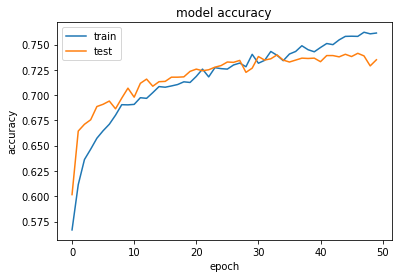

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

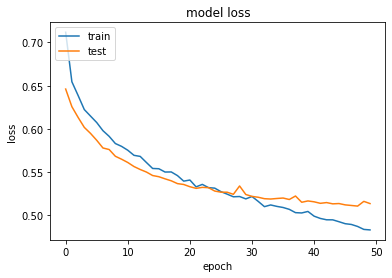

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [ ]:
#change to any directory of your preference
os.chdir('/content/drive/MyDrive/tcss555/')

In [ ]:
import pickle
pickle.dump(loaded_model, open('image_model1.sav','wb'))

INFO:tensorflow:Assets written to: ram://45065031-4039-4cfa-85f9-336b6004e0aa/assets


## Loading the model and running a prediction

In [ ]:
loaded_model = pickle.load(open('image_model1.sav', 'rb'))

In [ ]:
loaded_model.fit(x_test, y_test)

75/75 [==============================] - 17s 90ms/step - loss: 0.4939 - accuracy: 0.7524


In [ ]:
pred = loaded_model.predict(x_test)

In [ ]:
classes_x=np.argmax(pred,axis=1)
classes_x = classes_x.astype('float32')

In [ ]:
test_labels = np.argmax(y_test, axis=1)
test_labels = test_labels.astype('float32')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels,classes_x)

0.7725677830940989